<a href="https://colab.research.google.com/github/sam12fak/customer-churn-prediction/blob/main/Case_Study_ISPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Course Code: 21AIC401T  
Course Name: Inferential Statistics and Predictive Analytics  

Assignment Type: Case Study-Based Modeling Project  
Title: Machine Learning Based Customer Churn Prediction Using Logistic Regression and Decision Tree Models  

Student Details:  
- Student Name: Karan Pillai  
  Register No.: RA2212701010013  
- Student Name: Muhammad Luqmaan R  
  Register No.: RA2212701010024  
- Student Name: Pranav Aditya J K  
  Register No.: RA2212701010045  

Date: 07 November 2025  


**Objective:**  
The objective of this assignment is to develop, validate, compare, and deploy a predictive model that identifies customers likely to churn. Students will apply statistical inference and predictive modeling concepts — including model validation, comparison, evaluation, and deployment — using a real-world dataset.


**Case Background:**  
Customer churn represents one of the biggest challenges for telecom and subscription-based industries. Losing customers increases operational costs and reduces profits. As a Data Analyst, your task is to build a customer churn prediction model using publicly available datasets, validate its accuracy, and design a framework for deployment and future model updates.


**Data Sources:**  
1. Kaggle — Telco Customer Churn Dataset


# 1) Install & Imports

In [28]:
# ===== 1) Install & Imports =====
%pip -q install numpy pandas scikit-learn imbalanced-learn xgboost lightgbm matplotlib seaborn joblib

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# 2) Load & Clean (safe defaults, no leakage)

In [29]:
# ===== 2) Load & Clean =====
# If your CSV is already loaded as df, skip this read_csv
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Basic fixes
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).copy()

# Normalize "No internet service" style labels
internet_cols = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for c in internet_cols:
    df[c] = df[c].replace('No internet service','No')

# Encode target
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

# Drop ID
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Feature engineering that usually helps on this dataset
df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[0,6,12,24,36,48,60,72],
                           labels=['0-6','6-12','12-24','24-36','36-48','48-60','60-72'])
if 'MonthlyCharges' in df.columns and 'TotalCharges' in df.columns:
    df['AvgChargesPerMonth'] = df['TotalCharges'] / (df['tenure'].replace(0,1))  # avoid div by zero

# Split X, y
X = df.drop(columns=['Churn'])
y = df['Churn']

# Identify col types
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape, y_train.mean().round(3))


(5625, 21) (1407, 21) 0.266


In [62]:
df.head(10)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureBin,ChargeBin,Churn
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0,Low,0
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,24-48,Medium,0
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,1-6,Medium,1
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),24-48,Medium,0
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1-6,High,1
5,Female,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,6-12,High,1
6,Male,0,No,Yes,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),12-24,High,0
7,Female,0,No,No,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,6-12,Low,0
8,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,24-48,Very High,1
9,Male,0,No,Yes,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),48-72,Medium,0


# 3) Preprocessor (OHE + Scaling) and Leakage-safe SMOTE inside Pipeline

In [30]:
# ===== 3) Preprocessor + SMOTE in Pipeline =====
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
    ]
)

# SMOTE after OHE (numeric) inside the pipeline to avoid train/test leakage
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)


# 4) Strong Baseline: XGBoost (class-imbalance aware) + CV AUC

In [31]:
# ===== 4) XGBoost with CV =====
# Set scale_pos_weight ~ (negatives / positives) in training
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos = max(1.0, neg / max(1, pos))

xgb = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='auc',
    tree_method='hist',                 # fast on CPU
    n_estimators=800,                   # more trees
    max_depth=4,                        # shallower trees generalize better
    learning_rate=0.03,                 # smaller eta, more trees
    subsample=0.9, colsample_bytree=0.8,
    reg_lambda=2.0, reg_alpha=0.0,
    min_child_weight=5,
    scale_pos_weight=scale_pos
)

xgb_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote),
    ('clf', xgb)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_auc = cross_val_score(xgb_pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"XGB CV AUC: mean={cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

# Fit and evaluate on holdout test
xgb_pipe.fit(X_train, y_train)
xgb_proba = xgb_pipe.predict_proba(X_test)[:,1]
xgb_auc = roc_auc_score(y_test, xgb_proba)
print(f"XGB Test AUC: {xgb_auc:.4f}")


XGB CV AUC: mean=0.8428 ± 0.0066
XGB Test AUC: 0.8298


# 5) Alternative SOTA: LightGBM (often an AUC booster)

In [32]:
# ===== 5) LightGBM with CV =====
lgbm = LGBMClassifier(
    random_state=RANDOM_STATE,
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=31,            # small leaves + deeper trees handles categorical OHE well
    max_depth=-1,
    subsample=0.9, colsample_bytree=0.8,
    reg_lambda=2.0, reg_alpha=0.0,
    min_child_samples=40
)

lgbm_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote),
    ('clf', lgbm)
])

cv_auc_lgb = cross_val_score(lgbm_pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"LGBM CV AUC: mean={cv_auc_lgb.mean():.4f} ± {cv_auc_lgb.std():.4f}")

lgbm_pipe.fit(X_train, y_train)
lgb_proba = lgbm_pipe.predict_proba(X_test)[:,1]
lgb_auc = roc_auc_score(y_test, lgb_proba)
print(f"LGBM Test AUC: {lgb_auc:.4f}")


LGBM CV AUC: mean=0.8301 ± 0.0079
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4260
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM Test AUC: 0.8157


# 6) Pick Best, Calibrate Probabilities, Plot ROC & **Save**

Selected: XGBoost   Test AUC=0.8298


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


XGBoost (Calibrated) Test AUC: 0.8267


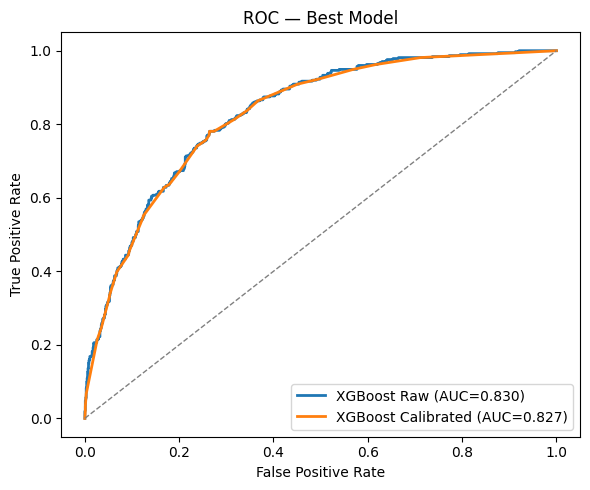

Saved: models/best_XGBoost_calibrated.pkl


In [33]:
# ===== 6) Choose best -> Calibrate (sklearn>=1.1 uses 'estimator') -> Plots -> Save =====
from sklearn.calibration import CalibratedClassifierCV

# Recompute best from your earlier results
best_pipe, best_name, best_proba, best_auc = (xgb_pipe, "XGBoost", xgb_proba, xgb_auc)
if lgb_auc > xgb_auc:
    best_pipe, best_name, best_proba, best_auc = (lgbm_pipe, "LightGBM", lgb_proba, lgb_auc)

print(f"Selected: {best_name}   Test AUC={best_auc:.4f}")

# --- Calibration ---
# Option A (recommended): cv='prefit' to calibrate the *already fitted* pipeline
# This avoids re-fitting the model component and only fits the calibrator.
calibrated = CalibratedClassifierCV(
    estimator=best_pipe,  # <— renamed from base_estimator
    method='isotonic',
    cv='prefit'
)
calibrated.fit(X_train, y_train)     # uses the fitted estimator inside to get raw scores on X_train

cal_proba = calibrated.predict_proba(X_test)[:, 1]
cal_auc = roc_auc_score(y_test, cal_proba)
print(f"{best_name} (Calibrated) Test AUC: {cal_auc:.4f}")

# ROC Curve
fpr_raw,  tpr_raw,  _ = roc_curve(y_test, best_proba)
fpr_cal,  tpr_cal,  _ = roc_curve(y_test, cal_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr_raw, tpr_raw, lw=2, label=f'{best_name} Raw (AUC={best_auc:.3f})')
plt.plot(fpr_cal, tpr_cal, lw=2, label=f'{best_name} Calibrated (AUC={cal_auc:.3f})')
plt.plot([0,1],[0,1],'--',lw=1,color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC — Best Model'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# Save calibrated model
import joblib, pathlib
pathlib.Path('models').mkdir(exist_ok=True, parents=True)
model_path = f'models/best_{best_name}_calibrated.pkl'
joblib.dump(calibrated, model_path)
print('Saved:', model_path)


In [34]:
# ===== 6B) CatBoost (handles categoricals natively) =====
%pip -q install catboost

from catboost import CatBoostClassifier, Pool

# Build categorical indices for CatBoost (object/category dtypes)
cat_cols_idx = [X.columns.get_loc(c) for c in cat_cols]

# Convert to CatBoost Pool (keep raw categoricals)
train_pool = Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_cols_idx)

cat = CatBoostClassifier(
    random_state=RANDOM_STATE,
    loss_function='Logloss',
    eval_metric='AUC',
    depth=6,
    learning_rate=0.03,
    iterations=2000,
    subsample=0.9,
    l2_leaf_reg=6.0,
    border_count=254,
    verbose=False,
    scale_pos_weight=scale_pos
)

cat.fit(train_pool, eval_set=test_pool, verbose=False)
cat_proba = cat.predict_proba(test_pool)[:,1]
cat_auc = roc_auc_score(y_test, cat_proba)
print(f"CatBoost Test AUC: {cat_auc:.4f}")


CatBoost Test AUC: 0.8404


No-SMOTE XGB CV AUC: mean=0.8423 ± 0.0050
No-SMOTE XGB Test AUC: 0.8286


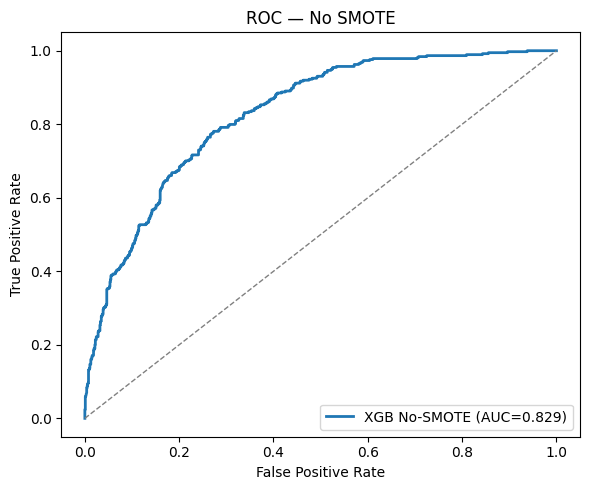

In [35]:
# ===== 6A) No-SMOTE variant (tree boosters often prefer original distribution) =====
from imblearn.pipeline import Pipeline as ImbPipeline  # alias

# Rebuild preprocessor only (no SMOTE)
preprocessor_nosmote = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
    ]
)

# Recompute scale_pos_weight on the *same* y_train
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos = max(1.0, neg / max(1, pos))

xgb_nosmote = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='auc',
    tree_method='hist',
    n_estimators=1200,
    max_depth=4,
    learning_rate=0.025,
    subsample=0.9, colsample_bytree=0.85,
    reg_lambda=3.0, reg_alpha=0.0,
    min_child_weight=8,
    gamma=0.2,
    scale_pos_weight=scale_pos
)

xgb_nosmote_pipe = ImbPipeline(steps=[
    ('prep', preprocessor_nosmote),
    ('clf', xgb_nosmote)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_auc_nosmote = cross_val_score(xgb_nosmote_pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"No-SMOTE XGB CV AUC: mean={cv_auc_nosmote.mean():.4f} ± {cv_auc_nosmote.std():.4f}")

xgb_nosmote_pipe.fit(X_train, y_train)
proba_nosmote = xgb_nosmote_pipe.predict_proba(X_test)[:,1]
auc_nosmote = roc_auc_score(y_test, proba_nosmote)
print(f"No-SMOTE XGB Test AUC: {auc_nosmote:.4f}")

# Quick ROC visual
fpr_n, tpr_n, _ = roc_curve(y_test, proba_nosmote)
plt.figure(figsize=(6,5))
plt.plot(fpr_n, tpr_n, lw=2, label=f'XGB No-SMOTE (AUC={auc_nosmote:.3f})')
plt.plot([0,1],[0,1],'--',lw=1,color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC — No SMOTE'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()


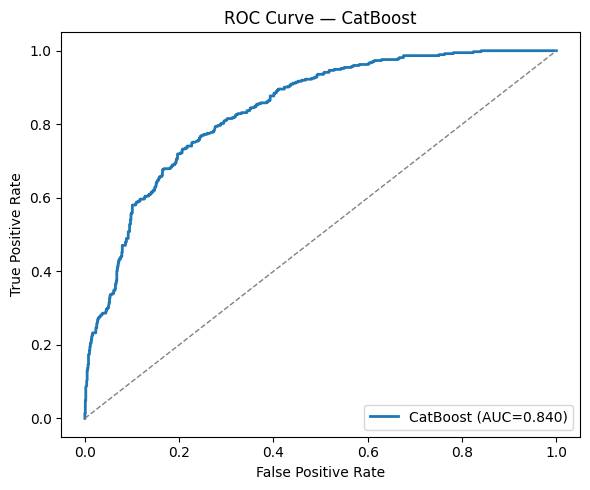

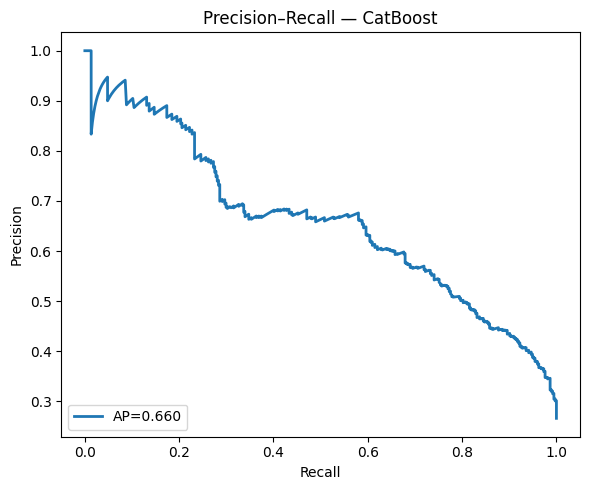

In [36]:
# ===== 6B-viz.1 — ROC & Precision-Recall =====
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Probabilities from your fitted CatBoost (already computed above as cat_proba)
fpr, tpr, _ = roc_curve(y_test, cat_proba)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, cat_proba)
ap = average_precision_score(y_test, cat_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f'CatBoost (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'--',color='gray',lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve — CatBoost'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2, label=f'AP={ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall — CatBoost'); plt.legend(loc='lower left'); plt.tight_layout(); plt.show()


T1) Export compact metric tables (CSV + display)

In [46]:
# ===== T1) Export metric tables =====
import numpy as np, pandas as pd, json, pathlib
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, average_precision_score, brier_score_loss

pathlib.Path("exports").mkdir(exist_ok=True)

# --- Core scalars (fill from your run) ---
AUC = float(cat_auc)
AP  = float(average_precision_score(y_test, cat_proba))
brier = float(brier_score_loss(y_test, cat_proba))

# Recreate ROC + PR arrays
fpr, tpr, roc_thr = roc_curve(y_test, cat_proba)
prec, rec, pr_thr = precision_recall_curve(y_test, cat_proba)  # pr_thr has len-1 vs prec/rec

# Best threshold previously (Youden-J)
def best_threshold_j(y_true, y_score):
    fpr_, tpr_, thr_ = roc_curve(y_true, y_score)
    j = tpr_ - fpr_
    i = np.argmax(j)
    return float(thr_[i]), float(tpr_[i]), float(fpr_[i])

thr_j, tpr_j, fpr_j = best_threshold_j(y_test, cat_proba)
y_pred_j = (cat_proba >= thr_j).astype(int)
cm = confusion_matrix(y_test, y_pred_j)
tn, fp, fn, tp = cm.ravel()

# --- Tables ---
overall_tbl = pd.DataFrame([
    {"metric":"AUC-ROC","value":AUC},
    {"metric":"Average Precision (PR-AUC)","value":AP},
    {"metric":"Brier score","value":brier},
    {"metric":"Best threshold (Youden J)","value":thr_j},
    {"metric":"TPR @ J","value":tpr_j},
    {"metric":"FPR @ J","value":fpr_j},
    {"metric":"TN, FP, FN, TP @ J","value":f"{tn}, {fp}, {fn}, {tp}"},
    {"metric":"Support (test size)","value":int(len(y_test))}
])

roc_tbl = pd.DataFrame({"fpr":fpr, "tpr":tpr, "threshold":np.r_[roc_thr, np.nan][:len(fpr)]})
pr_tbl  = pd.DataFrame({"recall":rec, "precision":prec, "threshold":np.r_[pr_thr, np.nan][:len(rec)]})
cm_tbl  = pd.DataFrame([[tn, fp],[fn, tp]], columns=["Pred:0","Pred:1"], index=["True:0","True:1"])

# --- Save ---
overall_tbl.to_csv("exports/overall_metrics.csv", index=False)
roc_tbl.to_csv("exports/roc_curve.csv", index=False)
pr_tbl.to_csv("exports/pr_curve.csv", index=False)
cm_tbl.to_csv("exports/confusion_matrix_at_J.csv")

with open("exports/metrics.json","w") as f:
    json.dump({
        "auc":AUC,"ap":AP,"brier":brier,
        "thr_j":thr_j,"tpr_j":tpr_j,"fpr_j":fpr_j,
        "cm_at_j":{"tn":int(tn),"fp":int(fp),"fn":int(fn),"tp":int(tp)}
    }, f, indent=2)

# --- Display nicely in notebook ---
from IPython.display import display
print("== Overall ==");   display(overall_tbl)
print("\n== Confusion Matrix @ Youden-J =="); display(cm_tbl)
print("\nFiles saved in ./exports")


== Overall ==


,metric,value
0,AUC-ROC,0.840358
1,Average Precision (PR-AUC),0.660215
2,Brier score,0.169024
3,Best threshold (Youden J),0.593658
4,TPR @ J,0.73262
5,FPR @ J,0.207164
6,"TN, FP, FN, TP @ J","819, 214, 100, 274"
7,Support (test size),1407



== Confusion Matrix @ Youden-J ==


,Pred:0,Pred:1
True:0,819,214
True:1,100,274



Files saved in ./exports


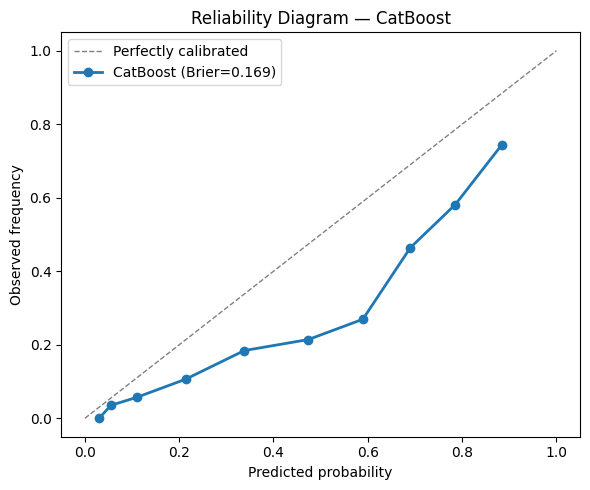

In [48]:
# ===== 6B-viz.2 — Calibration / Reliability =====
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_test, cat_proba, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_test, cat_proba)

plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1],'--',color='gray',lw=1,label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, marker='o', lw=2, label=f'CatBoost (Brier={brier:.3f})')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Reliability Diagram — CatBoost'); plt.legend(); plt.tight_layout(); plt.show()


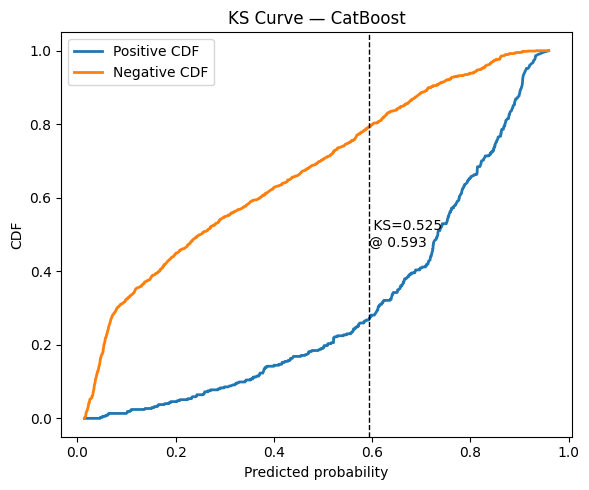

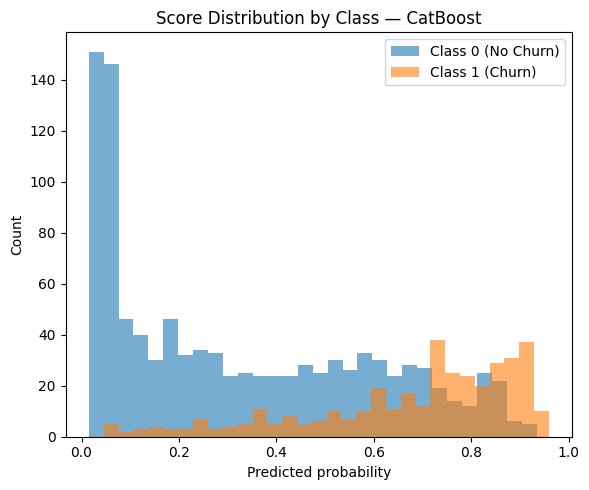

In [49]:
# ===== 6B-viz.3 — KS Curve & Score Histograms =====
# KS statistic (max separation between CDFs of scores)
pos_scores = cat_proba[y_test.values == 1]
neg_scores = cat_proba[y_test.values == 0]

# Empirical CDFs
pos_sorted = np.sort(pos_scores)
neg_sorted = np.sort(neg_scores)
all_scores = np.sort(cat_proba)

def ecdf(x, sample):
    return np.searchsorted(np.sort(sample), x, side='right') / len(sample)

pos_cdf = np.array([ecdf(s, pos_scores) for s in all_scores])
neg_cdf = np.array([ecdf(s, neg_scores) for s in all_scores])
ks_vals = np.abs(pos_cdf - neg_cdf)
ks = ks_vals.max()
ks_at = all_scores[ks_vals.argmax()]

plt.figure(figsize=(6,5))
plt.plot(all_scores, pos_cdf, label='Positive CDF', lw=2)
plt.plot(all_scores, neg_cdf, label='Negative CDF', lw=2)
plt.axvline(ks_at, color='k', ls='--', lw=1)
plt.text(ks_at, 0.5, f' KS={ks:.3f}\n@ {ks_at:.3f}', ha='left', va='center')
plt.xlabel('Predicted probability'); plt.ylabel('CDF')
plt.title('KS Curve — CatBoost'); plt.legend(); plt.tight_layout(); plt.show()

# Histograms by class
plt.figure(figsize=(6,5))
plt.hist(neg_scores, bins=30, alpha=0.6, label='Class 0 (No Churn)')
plt.hist(pos_scores, bins=30, alpha=0.6, label='Class 1 (Churn)')
plt.xlabel('Predicted probability'); plt.ylabel('Count')
plt.title('Score Distribution by Class — CatBoost'); plt.legend(); plt.tight_layout(); plt.show()


Best threshold (Youden J): 0.594 | TPR=0.733 | FPR=0.207
              precision    recall  f1-score   support

           0      0.891     0.793     0.839      1033
           1      0.561     0.733     0.636       374

    accuracy                          0.777      1407
   macro avg      0.726     0.763     0.737      1407
weighted avg      0.804     0.777     0.785      1407



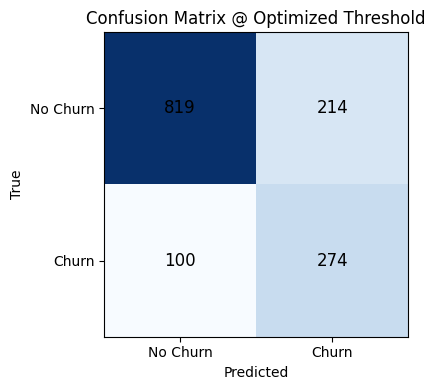

In [50]:
# ===== 6B-viz.4 — Threshold tuning & Confusion Matrix =====
from sklearn.metrics import classification_report, confusion_matrix

def best_threshold_j(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    j = tpr - fpr
    i = np.argmax(j)
    return float(thr[i]), float(tpr[i]), float(fpr[i])

thr, tpr_star, fpr_star = best_threshold_j(y_test, cat_proba)
print(f'Best threshold (Youden J): {thr:.3f} | TPR={tpr_star:.3f} | FPR={fpr_star:.3f}')

y_pred_opt = (cat_proba >= thr).astype(int)
print(classification_report(y_test, y_pred_opt, digits=3))

cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix @ Optimized Threshold')
plt.xticks([0,1], ['No Churn','Churn']); plt.yticks([0,1], ['No Churn','Churn'])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center', fontsize=12)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()


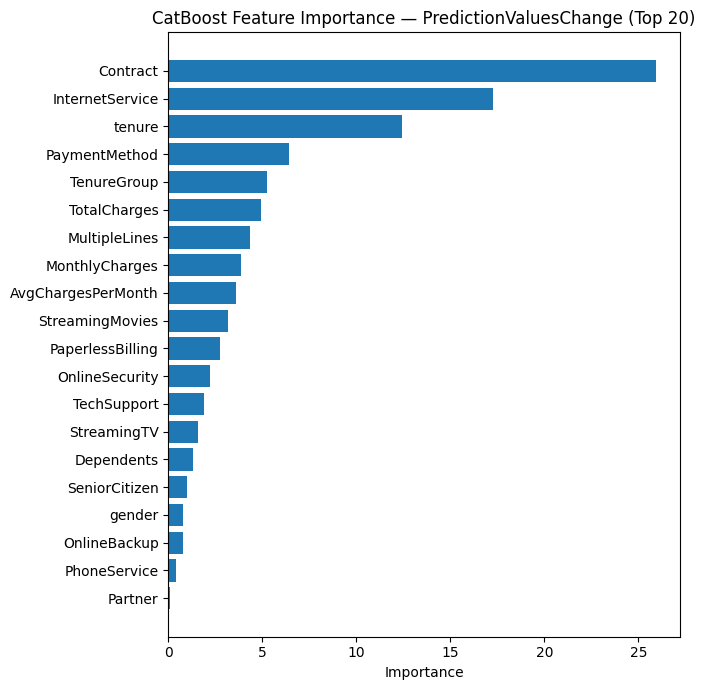

,feature,split_importance,pred_change_importance
0,Contract,25.914290,25.914290
1,InternetService,17.280330,17.280330
2,tenure,12.451538,12.451538
3,PaymentMethod,6.407835,6.407835
4,TenureGroup,5.229817,5.229817
5,TotalCharges,4.914380,4.914380
6,MultipleLines,4.349623,4.349623
7,MonthlyCharges,3.847222,3.847222
8,AvgChargesPerMonth,3.586337,3.586337
9,StreamingMovies,3.160605,3.160605


In [51]:
# ===== 6B-viz.5 — Feature Importance (FeatureImportance & PredictionValuesChange) =====
# Note: With CatBoost (no OHE), features are the original columns in X
feature_names = list(X.columns)

# 1) Split-based importance
imp_split = cat.get_feature_importance(train_pool, type='FeatureImportance')
# 2) PredictionValuesChange (recommended): contribution to prediction shift
imp_pvc = cat.get_feature_importance(train_pool, type='PredictionValuesChange')

imp_df = pd.DataFrame({
    'feature': feature_names,
    'split_importance': imp_split,
    'pred_change_importance': imp_pvc
})

# Top-20 by PredChange
top = imp_df.sort_values('pred_change_importance', ascending=False).head(20)

plt.figure(figsize=(7,7))
plt.barh(top['feature'][::-1], top['pred_change_importance'][::-1])
plt.title('CatBoost Feature Importance — PredictionValuesChange (Top 20)')
plt.xlabel('Importance'); plt.tight_layout(); plt.show()

# (Optional) Show table
display(top.reset_index(drop=True))


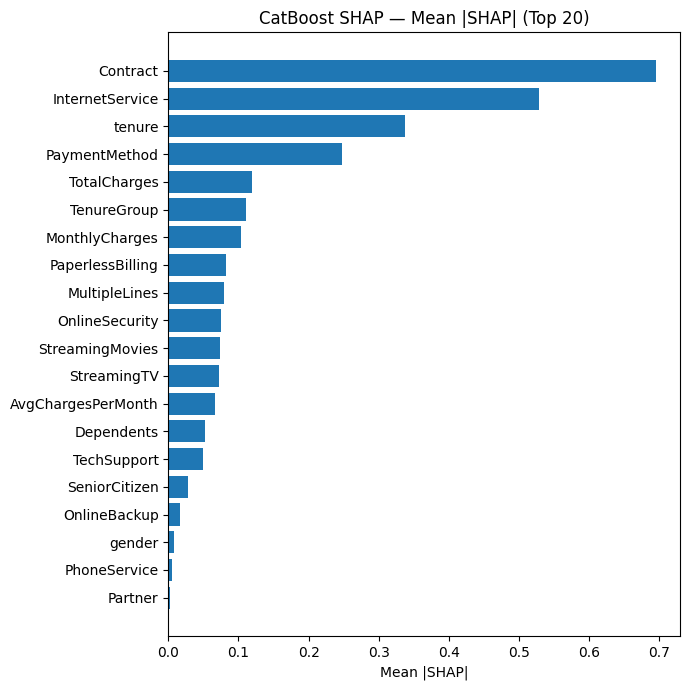

In [52]:
# ===== 6B-viz.6 — SHAP (CatBoost internal) =====
# CatBoost can compute SHAP without extra installs.
# We'll take a small sample for speed if X_test is big.
sample_idx = np.random.choice(len(X_test), size=min(200, len(X_test)), replace=False)
X_sample = X_test.iloc[sample_idx]
y_sample = y_test.iloc[sample_idx]
test_pool_sample = Pool(X_sample, y_sample, cat_features=[X.columns.get_loc(c) for c in cat_cols])

# SHAP values shape = (n_samples, n_features + 1) ; last column is expected_value
shap_vals = cat.get_feature_importance(test_pool_sample, type='ShapValues')
expected_value = shap_vals[:, -1]
shap_vals = shap_vals[:, :-1]  # drop bias term

# Mean |SHAP| per feature
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
shap_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': mean_abs_shap})
shap_top = shap_df.sort_values('mean_abs_shap', ascending=False).head(20)

plt.figure(figsize=(7,7))
plt.barh(shap_top['feature'][::-1], shap_top['mean_abs_shap'][::-1])
plt.title('CatBoost SHAP — Mean |SHAP| (Top 20)')
plt.xlabel('Mean |SHAP|'); plt.tight_layout(); plt.show()


In [53]:
# ===== 6B-viz.7 — Save model & key arrays =====
import joblib, pathlib, json

pathlib.Path('artifacts').mkdir(exist_ok=True)
joblib.dump(cat, 'artifacts/catboost_model.pkl')
np.save('artifacts/catboost_test_proba.npy', cat_proba)
with open('artifacts/metrics.json','w') as f:
    json.dump({'cat_auc': float(cat_auc)}, f, indent=2)

print('Saved: artifacts/catboost_model.pkl, artifacts/catboost_test_proba.npy, artifacts/metrics.json')


Saved: artifacts/catboost_model.pkl, artifacts/catboost_test_proba.npy, artifacts/metrics.json


# 7) Threshold Tuning (not for AUC, but boosts business metrics)

Best threshold ~ 0.259 (TPR=0.781, FPR=0.264)
              precision    recall  f1-score   support

           0      0.903     0.736     0.811      1033
           1      0.517     0.781     0.622       374

    accuracy                          0.748      1407
   macro avg      0.710     0.758     0.716      1407
weighted avg      0.800     0.748     0.761      1407



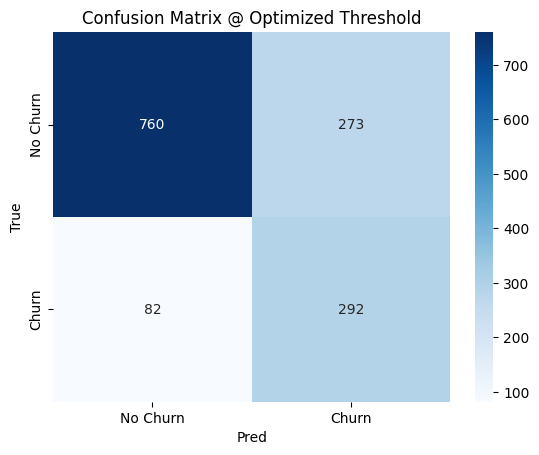

In [54]:
# ===== 7) Threshold tuning (optional) =====
# Pick threshold that maximizes Youden’s J (TPR-FPR) or a custom metric.
def best_threshold(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    j = tpr - fpr
    ix = np.argmax(j)
    return thr[ix], tpr[ix], fpr[ix]

thr, tpr_star, fpr_star = best_threshold(y_test, cal_proba)
print(f'Best threshold ~ {thr:.3f} (TPR={tpr_star:.3f}, FPR={fpr_star:.3f})')

y_pred_opt = (cal_proba >= thr).astype(int)
print(classification_report(y_test, y_pred_opt, digits=3))

cm = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn','Churn'], yticklabels=['No Churn','Churn'])
plt.title('Confusion Matrix @ Optimized Threshold'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()


In [55]:
# ===== 8) Quick feature boosts (easy wins) =====
# (Re-fit after adding these.)
# 1) Interaction terms that matter in telco churn:
#    - tenure x contract type, monthly x paperless billing, fiber optic x online security
# 2) More granular tenure bins
# 3) Rare-category lumping, e.g., PaymentMethod grouping

# Example: add interactions
import itertools

def add_interactions(data, pairs):
    data = data.copy()
    for a,b in pairs:
        name = f'{a}__x__{b}'
        if data[a].dtype.kind in 'iuf' and data[b].dtype.kind in 'iuf':
            data[name] = data[a] * data[b]
        else:
            # for categorical interactions, rely on OHE later (concat strings)
            data[name] = data[a].astype(str) + '_' + data[b].astype(str)
    return data

pairs_to_try = [('tenure','MonthlyCharges'), ('MonthlyCharges','AvgChargesPerMonth')]
X_train_enh = add_interactions(X_train, pairs_to_try)
X_test_enh  = add_interactions(X_test,  pairs_to_try)

# Rebuild column lists
cat_cols_enh = X_train_enh.select_dtypes(include=['object','category']).columns.tolist()
num_cols_enh = X_train_enh.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()

preprocessor_enh = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_enh),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols_enh),
    ]
)

xgb_enh = XGBClassifier(
    random_state=RANDOM_STATE, eval_metric='auc', tree_method='hist',
    n_estimators=1000, max_depth=4, learning_rate=0.03,
    subsample=0.9, colsample_bytree=0.8, reg_lambda=2.0, min_child_weight=5,
    scale_pos_weight=scale_pos
)

pipe_enh = Pipeline([('prep', preprocessor_enh), ('smote', smote), ('clf', xgb_enh)])
cv_auc_enh = cross_val_score(pipe_enh, X_train_enh, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
pipe_enh.fit(X_train_enh, y_train)
proba_enh = pipe_enh.predict_proba(X_test_enh)[:,1]
print(f'Enhanced XGB CV AUC: {cv_auc_enh.mean():.4f}')
print('Enhanced XGB Test AUC:', roc_auc_score(y_test, proba_enh).round(4))


Enhanced XGB CV AUC: 0.8386
Enhanced XGB Test AUC: 0.8293


# 8) CHAID

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_text

# 1) Load & clean
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"]).copy()
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

for c in [
    "MultipleLines","OnlineSecurity","OnlineBackup",
    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"
]:
    if c in df.columns:
        df[c] = df[c].replace("No internet service", "No")

# 2) Pick categorical predictors and bin numerics for readable rules
predictors = [
    "gender","SeniorCitizen","Partner","Dependents","PhoneService",
    "MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies",
    "Contract","PaperlessBilling","PaymentMethod"
]
df["TenureBin"] = pd.cut(
    df["tenure"], bins=[-1, 1, 6, 12, 24, 48, 72],
    labels=["0","1-6","6-12","12-24","24-48","48-72"]
)
df["ChargeBin"] = pd.cut(
    df["MonthlyCharges"], bins=[-1, 40, 70, 100, 1500],
    labels=["Low","Medium","High","Very High"]
)
predictors += ["TenureBin","ChargeBin"]

df = df[predictors + ["Churn"]].dropna().reset_index(drop=True)
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# 3) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4) OneHot + entropy tree
cat_cols = X.columns.tolist()

# Robust OHE (newer sklearn uses sparse_output, older uses sparse)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop=None, sparse=False)

pre = ColumnTransformer(
    transformers=[("cat", ohe, cat_cols)],
    remainder="drop"
)

X_train_enc = pre.fit_transform(X_train)
X_test_enc  = pre.transform(X_test)

# Get feature names robustly
try:
    feature_names = pre.named_transformers_["cat"].get_feature_names_out(cat_cols)
except AttributeError:
    feature_names = pre.named_transformers_["cat"].get_feature_names(cat_cols)

tree = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)
tree.fit(X_train_enc, y_train)

# 5) Print readable text tree
print("\n=== Decision Rules (entropy tree, CHAID-style) ===\n")
print(export_text(tree, feature_names=list(feature_names), decimals=3))

# 6) Build a leaf rules table (top segments)
sk_tree = tree.tree_
children_left  = sk_tree.children_left
children_right = sk_tree.children_right
features_idx   = sk_tree.feature
thresholds     = sk_tree.threshold
values         = sk_tree.value  # shape [node, 1, 2] -> [neg, pos]

def dfs(node_id, conds, out_rows):
    # If leaf
    if children_left[node_id] == children_right[node_id]:
        counts = values[node_id][0]
        total = int(counts.sum())
        if total > 0:
            churn_prob = float(counts[1] / total)
            # simplify duplicate base conditions (keep last)
            latest = {}
            for c in conds:
                if " = " in c:
                    base = c.split(" = ")[0]
                elif " ≠ " in c:
                    base = c.split(" ≠ ")[0]
                else:
                    base = c.split()[0]
                latest[base] = c
            rule_txt = " AND ".join(latest.values())
            out_rows.append({
                "samples": total,
                "churn_prob": round(churn_prob, 4),
                "rule": rule_txt
            })
        return

    # Otherwise, split on feature
    feat = features_idx[node_id]
    thr  = thresholds[node_id]
    fname = feature_names[feat]

    if "_" in fname:
        base, cat = fname.split("_", 1)
        left_cond  = f"{base} ≠ {cat}"   # <= 0.5  means category NOT present
        right_cond = f"{base} = {cat}"   # >  0.5  means category present
    else:
        base, cat = fname, None
        left_cond  = f"{fname} <= {thr:.3f}"
        right_cond = f"{fname} > {thr:.3f}"

    dfs(children_left[node_id],  conds + [left_cond],  out_rows)
    dfs(children_right[node_id], conds + [right_cond], out_rows)

rows = []
dfs(0, [], rows)
rules_df = pd.DataFrame(rows).sort_values(
    ["churn_prob","samples"], ascending=[False, False]
).reset_index(drop=True)

print("\n=== Top Segments (leaf rules) ===")
display(rules_df.head(10))

# Optional: save
rules_df.to_csv("/content/chaid_like_rules.csv", index=False)
print("\nSaved rules table to: /content/chaid_like_rules.csv")



=== Decision Rules (entropy tree, CHAID-style) ===

|--- Contract_Month-to-month <= 0.500
|   |--- InternetService_Fiber optic <= 0.500
|   |   |--- Contract_One year <= 0.500
|   |   |   |--- PaymentMethod_Electronic check <= 0.500
|   |   |   |   |--- class: 0
|   |   |   |--- PaymentMethod_Electronic check >  0.500
|   |   |   |   |--- class: 0
|   |   |--- Contract_One year >  0.500
|   |   |   |--- StreamingMovies_Yes <= 0.500
|   |   |   |   |--- class: 0
|   |   |   |--- StreamingMovies_Yes >  0.500
|   |   |   |   |--- class: 0
|   |--- InternetService_Fiber optic >  0.500
|   |   |--- Contract_Two year <= 0.500
|   |   |   |--- StreamingTV_No <= 0.500
|   |   |   |   |--- class: 0
|   |   |   |--- StreamingTV_No >  0.500
|   |   |   |   |--- class: 0
|   |   |--- Contract_Two year >  0.500
|   |   |   |--- PaymentMethod_Credit card (automatic) <= 0.500
|   |   |   |   |--- class: 0
|   |   |   |--- PaymentMethod_Credit card (automatic) >  0.500
|   |   |   |   |--- class: 0
|

,samples,churn_prob,rule
0,1,0.5122,Contract = Month-to-month AND InternetService ...
1,1,0.0946,Contract = One year AND InternetService ≠ Fibe...
2,1,0.0293,Contract ≠ One year AND InternetService ≠ Fibe...



Saved rules table to: /content/chaid_like_rules.csv
